**Imports**

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import saraRC1 as sara

import os
import sys

In [3]:
IMG_DIR = '../ablation/images'
MASK_DIR = '../ablation/masks'

In [4]:
images = sorted([f for f in os.listdir(IMG_DIR) if f.endswith('.jpg')])
masks = sorted([f for f in os.listdir(MASK_DIR) if f.endswith('.png')])
names = []

with open(IMG_DIR + '/names.txt', 'r') as f:
    names = f.readlines()
    names = [x.strip() for x in names]

imgs = []
msks = []

for img in images:
    imgs.append(cv2.cvtColor(cv2.imread(os.path.join(IMG_DIR, img)), cv2.COLOR_BGR2RGB))
    msks.append(cv2.imread(os.path.join(MASK_DIR, img.replace('.jpg', '.png'))))

segments = {}

for img, mask, name in zip(imgs, msks, names):
    segments[name] = {}
    segments[name]['segments'] = []
    segments[name]['coordinates'] = []


    # Detect number of unique colors in the mask
    colors = np.unique(mask.reshape(-1, mask.shape[2]), axis=0)
    colors = [np.array(c) for c in colors]

    for i, color in enumerate(colors):
        if color[0] == 0 and color[1] == 0 and color[2] == 0:
            continue

        # Create a mask for the current color
        mask_color = cv2.inRange(mask, color, color)
        mask_color = cv2.cvtColor(mask_color, cv2.COLOR_GRAY2BGR)

        # Apply the mask to the image
        masked = cv2.bitwise_and(img, mask_color)

        # Find the bounding box of the mask
        gray = cv2.cvtColor(mask_color, cv2.COLOR_BGR2GRAY)
        _, thresh = cv2.threshold(gray, 1, 255, cv2.THRESH_BINARY)
        contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        x, y, w, h = cv2.boundingRect(contours[0])

        # Coordinates tuple which is top left, bottom right
        coord_tup = (i, x, y, x+w, y+h)

        # Crop the image to the bounding box
        cropped = masked[y:y+h, x:x+w]

        # Append the cropped image to the list of segments
        segments[name]['segments'].append(cropped)

        # Append the coordinates to the list of coordinates
        segments[name]['coordinates'].append(coord_tup)


pairs = [
    (0, 2),
    (1, 3),
    (4, 6),
    (5, 7)
]

**Load Images**

In [5]:
p = 0

img_a, img_b = imgs[pairs[p][0]], imgs[pairs[p][1]]
name_a, name_b = names[pairs[p][0]], names[pairs[p][1]]
mask_a, mask_b = msks[pairs[p][0]], msks[pairs[p][1]]

img_a_original = img_a.copy()
img_b_original = img_b.copy()

img_a = cv2.resize(img_a, (0, 0), fx=0.5, fy=0.5)
img_b = cv2.resize(img_b, (0, 0), fx=0.5, fy=0.5)

In [12]:
def get_saliency_map(img_original, name):
    saliency_map = sara.return_saliency(img_original, generator='itti', DEVICE='cpu')
    [sara_heatmap, text_overlay], sara_list = sara.return_sara(img_original.copy(), saliency_map=saliency_map, segments=segments[name]['segments'], coords=segments[name]['coordinates'], mode=2)

    overlay = img_original.copy()
    overlay = cv2.cvtColor(overlay, cv2.COLOR_RGB2RGBA)
    colormap = cv2.applyColorMap(sara_heatmap, cv2.COLORMAP_JET)
    colormap = cv2.cvtColor(colormap, cv2.COLOR_BGR2RGBA)

    sara_heatmap = cv2.cvtColor(sara_heatmap, cv2.COLOR_RGB2RGBA)
    sara_heatmap[:, :, 3] = np.where((sara_heatmap[:, :, :3] == [0, 0, 0]).all(axis=2), 0, 255)

    for i in range(3):
        sara_heatmap[:, :, i] = colormap[:, :, i]

    text_overlay = cv2.cvtColor(text_overlay, cv2.COLOR_RGB2RGBA)

    text_overlay[:, :, 3] = np.where((text_overlay[:, :, :3] < [64, 64, 64]).all(axis=2), 0, 255)
    text_overlay = cv2.GaussianBlur(text_overlay, (5, 5), 0)

    return saliency_map, sara_heatmap, text_overlay

In [13]:
saliency_map_a, sara_heatmap_a, text_overlay_a = get_saliency_map(img_a_original, name_a)
saliency_map_b, sara_heatmap_b, text_overlay_b = get_saliency_map(img_b_original, name_b)

KeyError: 'DESKTOP_B'

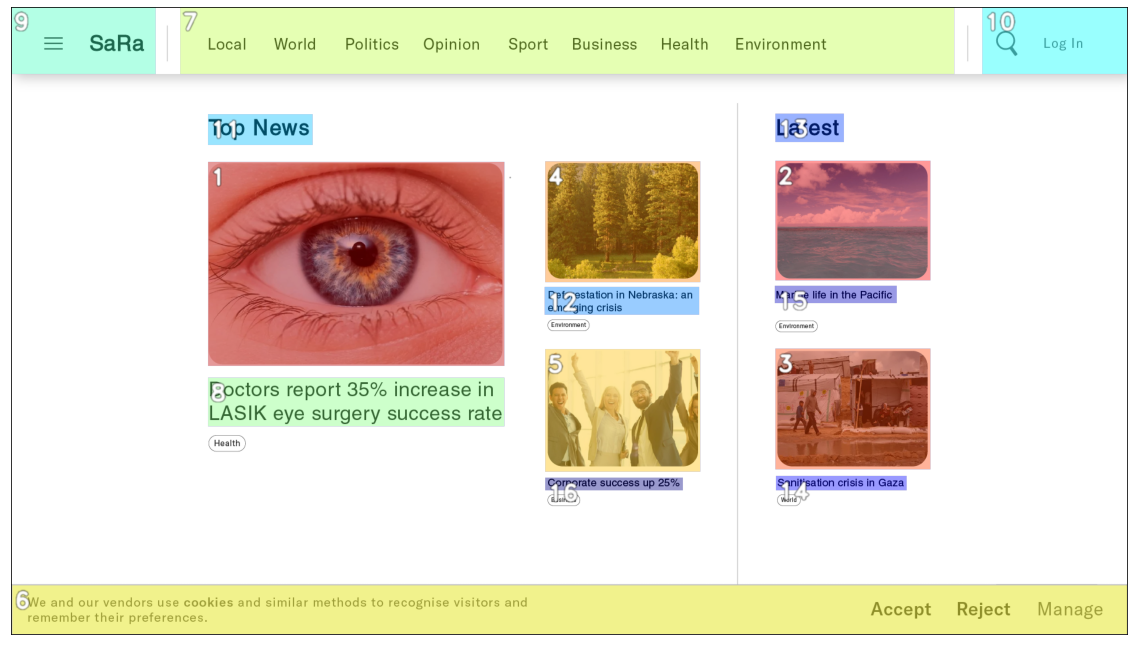

In [8]:
plt.figure(figsize=(20, 20))

plt.imshow(img_a_original)
plt.imshow(sara_heatmap_a, alpha=0.4)
plt.imshow(text_overlay_a)

plt.xticks([]), plt.yticks([])
# colorbar = plt.colorbar()
plt.show()

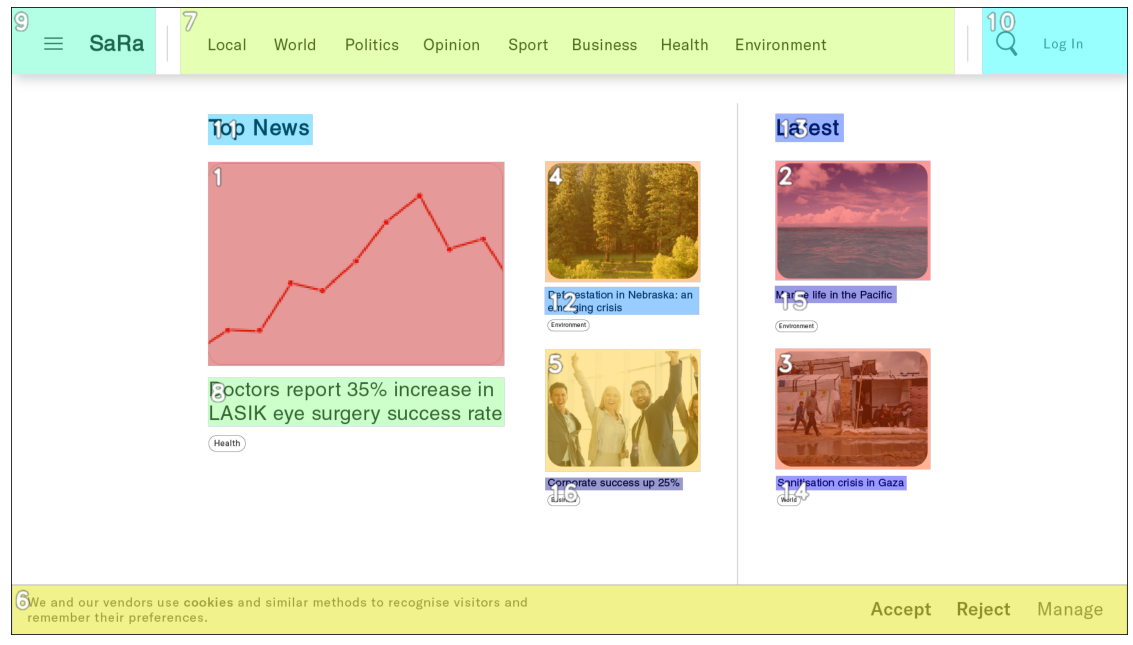

In [9]:
plt.figure(figsize=(20, 20))

plt.imshow(img_b_original)
plt.imshow(sara_heatmap_b, alpha=0.4)
plt.imshow(text_overlay_b)

plt.xticks([]), plt.yticks([])
# colorbar = plt.colorbar()
plt.show()

In [7]:
sara.segments_coords

[(1, 338, 638, 849, 723),
 (2, 290, 0, 1623, 117),
 (3, 0, 0, 249, 117),
 (4, 338, 267, 849, 619),
 (5, 918, 266, 1186, 475),
 (6, 1, 995, 1920, 1080),
 (7, 1314, 588, 1582, 797),
 (8, 917, 482, 1184, 531),
 (9, 918, 589, 1186, 801),
 (10, 918, 810, 1156, 833),
 (11, 1315, 807, 1541, 833),
 (12, 1314, 265, 1582, 472),
 (13, 1313, 480, 1524, 511),
 (14, 1314, 184, 1433, 234),
 (15, 1670, 0, 1920, 117),
 (16, 338, 185, 519, 239)]

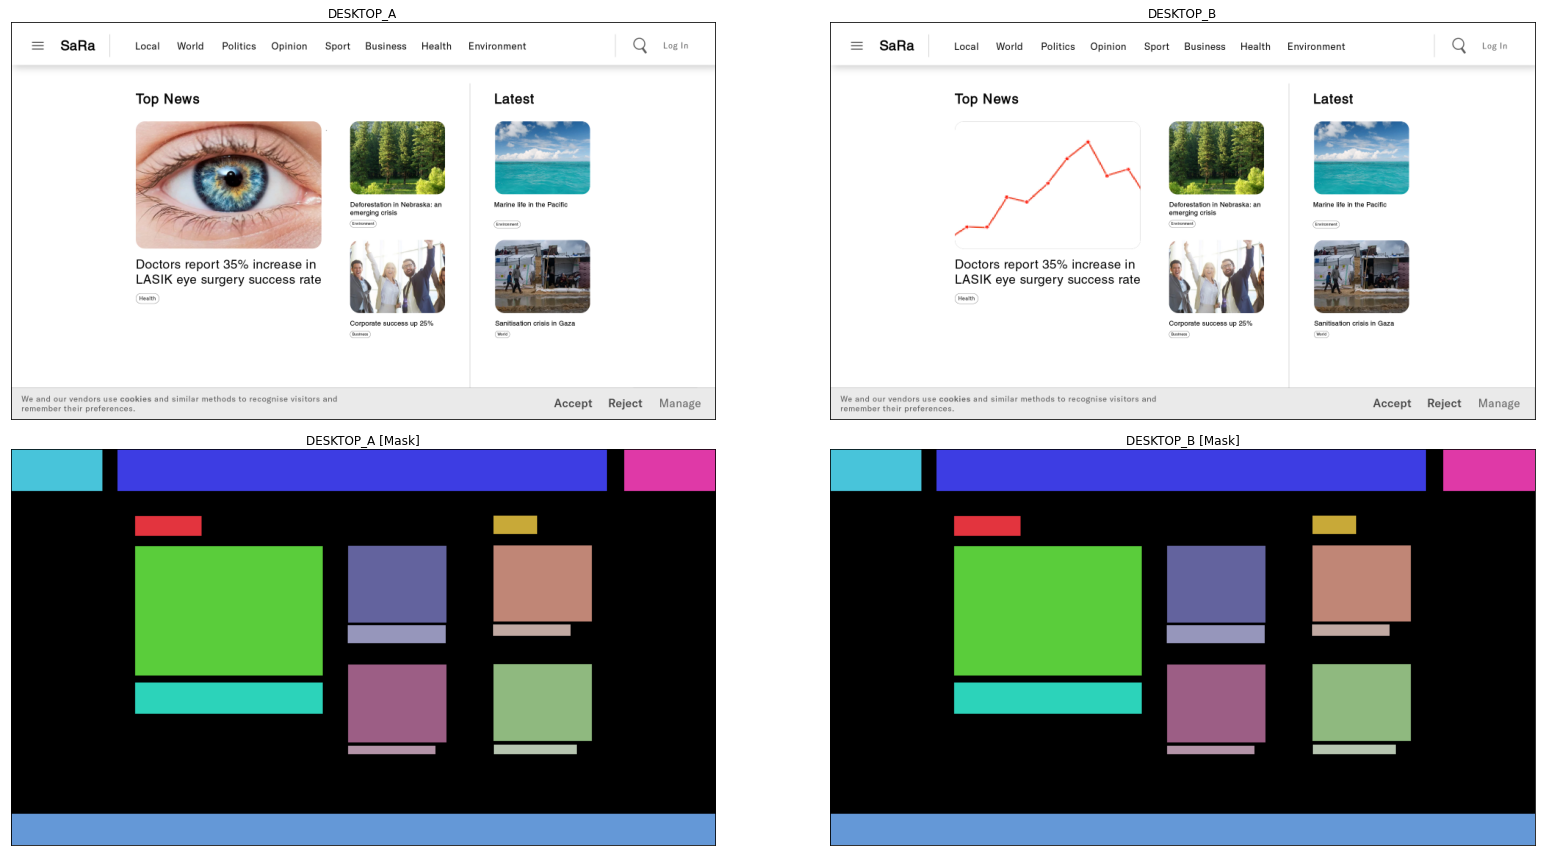

In [8]:
plt.figure(figsize=(24, 12))

plt.subplot(221)
plt.imshow(img_a)
plt.title(name_a)
plt.xticks([])
plt.yticks([])

plt.subplot(222)
plt.imshow(img_b)
plt.title(name_b)
plt.xticks([])
plt.yticks([])

plt.subplot(223)
plt.imshow(mask_a)
plt.title(name_a + ' [Mask]')
plt.xticks([])
plt.yticks([])

plt.subplot(224)
plt.imshow(mask_b)
plt.title(name_b + ' [Mask]')
plt.xticks([])
plt.yticks([])


plt.tight_layout()
plt.show()

**DeepGaze Model**

In [9]:
import deepgaze_pytorch
model = deepgaze_pytorch.DeepGazeIIE(pretrained=True).to('cuda')

Loaded pretrained weights for efficientnet-b5


Using cache found in /home/matthewkenely/.cache/torch/hub/pytorch_vision_v0.6.0
Using cache found in /home/matthewkenely/.cache/torch/hub/pytorch_vision_v0.6.0


****

In [10]:
saliency_map_a = sara.return_saliency(img_a, generator='deepgaze', deepgaze_model=model, DEVICE='cuda')
saliency_map_b = sara.return_saliency(img_b, generator='deepgaze', deepgaze_model=model, DEVICE='cuda')

/home/matthewkenely/Programming/Assignments/ICT3909 Final Year Project in Artificial Intelligence/ICT3909/saliency-ranking/saraRC1.py:116: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  ../torch/csrc/utils/tensor_new.cpp:201.)
  image_tensor = torch.tensor([image.transpose(2, 0, 1)]).to(DEVICE)


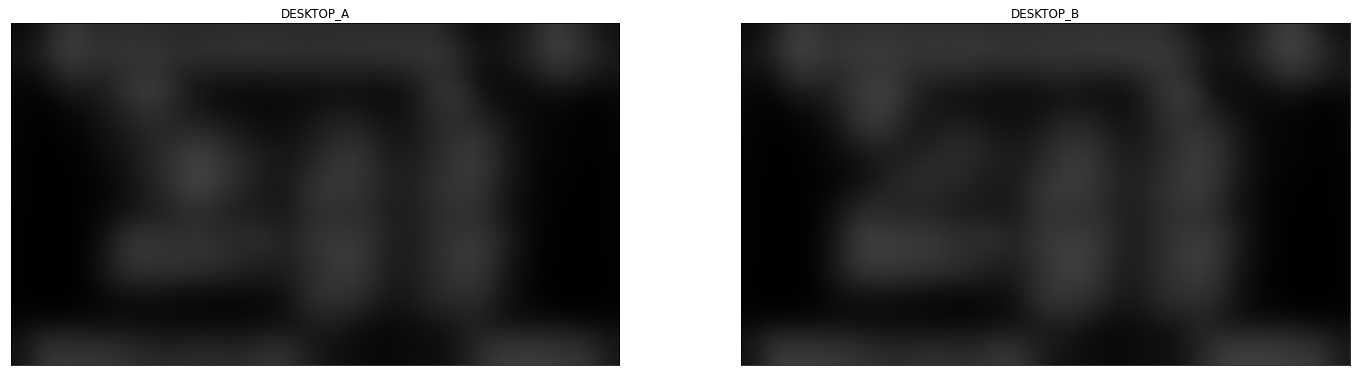

In [11]:
plt.figure(figsize=(24, 12))
plt.subplot(121)
plt.imshow(cv2.cvtColor(saliency_map_a, cv2.COLOR_BGR2RGB))
plt.title(name_a)
plt.xticks([])
plt.yticks([])

plt.subplot(122)
plt.imshow(cv2.cvtColor(saliency_map_b, cv2.COLOR_BGR2RGB))
plt.title(name_b)
plt.xticks([])
plt.yticks([])

plt.show()

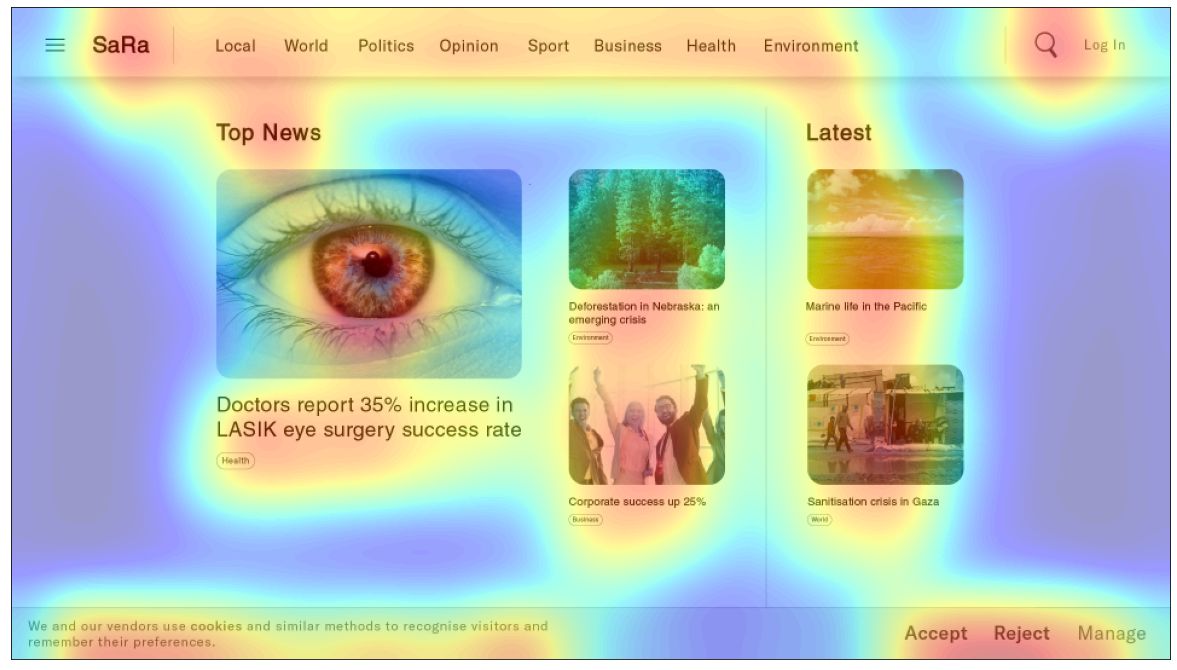

In [12]:
plt.figure(figsize=(24, 12))
plt.imshow(cv2.cvtColor(img_a, cv2.COLOR_BGR2RGB), cmap='gray')
plt.imshow(saliency_map_a, alpha=0.4, cmap='jet')
plt.xticks([]), plt.yticks([])
plt.show()

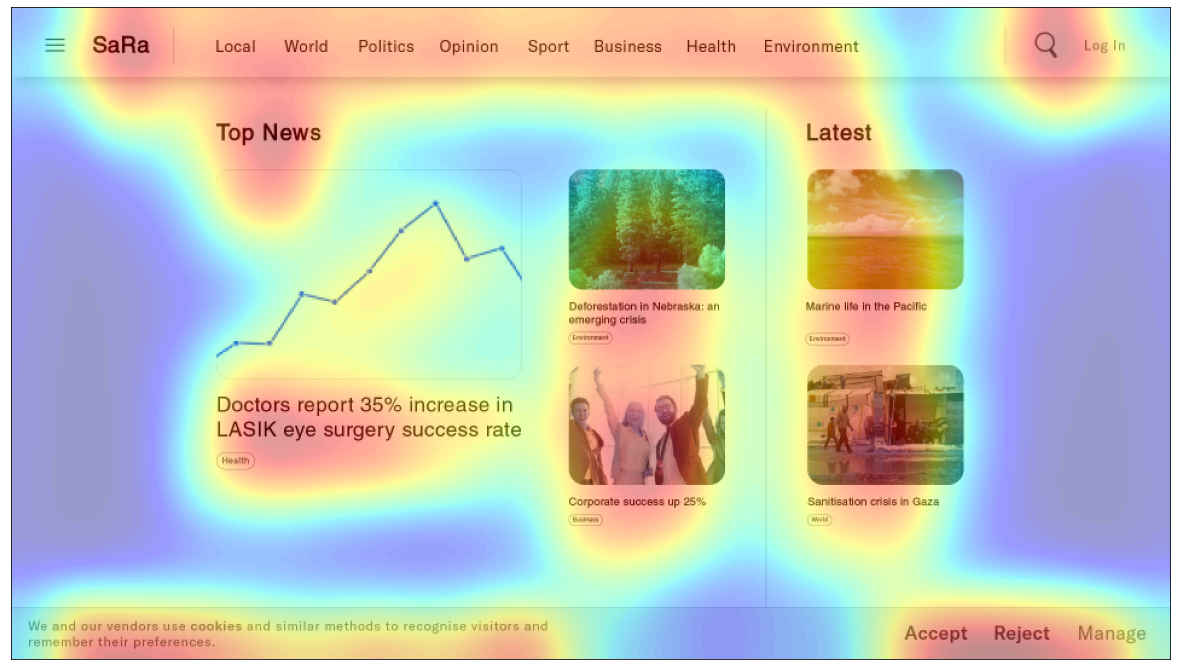

In [13]:
plt.figure(figsize=(24, 12))
plt.imshow(cv2.cvtColor(img_b, cv2.COLOR_BGR2RGB))
plt.imshow(saliency_map_b, alpha=0.4, cmap='jet')
plt.xticks([]), plt.yticks([])
plt.show()

In [14]:
GRID_SIZE = 6
sara.WEIGHTS = (1, 1, 1, 0)
im_bigger_a = img_a.copy()
sara_heatmap_a, sara_list_a = sara.return_sara(img_a.copy(), GRID_SIZE, saliency_map=saliency_map_a)
sara_heatmap_a = cv2.cvtColor(sara_heatmap_a, cv2.COLOR_BGR2RGB)
sara.reset()

In [15]:
GRID_SIZE = 6
sara.WEIGHTS = (1, 1, 1, 0)
im_bigger_b = img_b.copy()
sara_heatmap_b, sara_list_b = sara.return_sara(img_b.copy(), GRID_SIZE, saliency_map=saliency_map_b)
sara_heatmap_b = cv2.cvtColor(sara_heatmap_b, cv2.COLOR_BGR2RGB)
sara.reset()

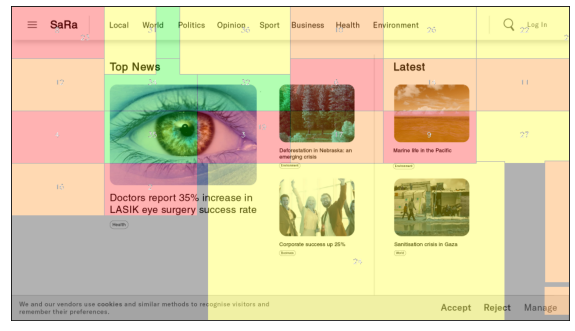

In [16]:
plt.figure(figsize=(10, 10))
plt.imshow(sara_heatmap_a)
plt.xticks([]), plt.yticks([])
plt.show()

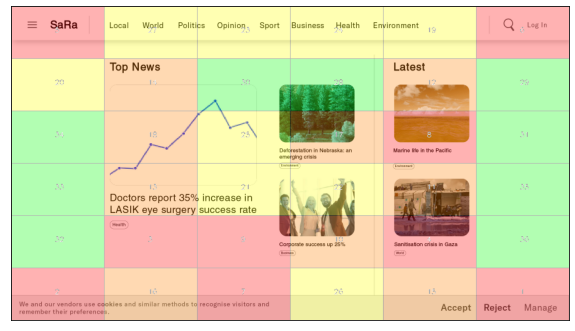

In [17]:
plt.figure(figsize=(10, 10))
plt.imshow(sara_heatmap_b)
plt.xticks([]), plt.yticks([])
plt.show()

In [18]:
[i[0] for i in sara_list_b]

[35,
 30,
 25,
 28,
 0,
 5,
 32,
 16,
 26,
 27,
 22,
 10,
 19,
 7,
 34,
 31,
 15,
 13,
 4,
 6,
 20,
 21,
 2,
 3,
 14,
 33,
 1,
 9,
 11,
 8,
 17,
 24,
 18,
 12,
 23,
 29]

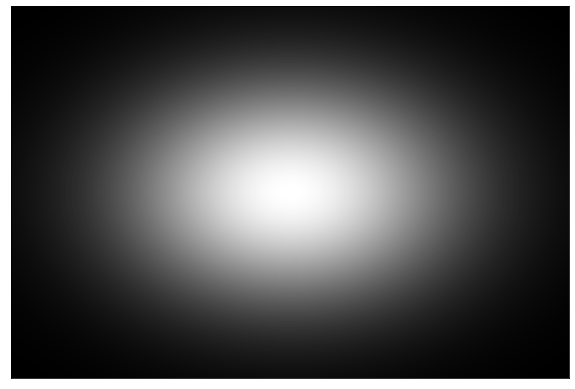

In [19]:
# Create a 512x512 image of agaussian kernel
kernel = cv2.getGaussianKernel(512, 106)
kernel = kernel * kernel.T
# Stretch to 1024 x 512
kernel = cv2.resize(kernel, (0, 0), fx=1.5, fy=1)

plt.figure(figsize=(10, 10))
plt.imshow(kernel, cmap='gray')
plt.xticks([]), plt.yticks([])
plt.show()

In [20]:
def index_to_coordinates(index, seg_dim, im_size):
    '''
    Given an index and a shape, this function returns the corresponding coordinates.
    '''

    x1 = int((index % seg_dim) * (im_size[1] / seg_dim))
    y1 = int((index // seg_dim) * (im_size[0] / seg_dim))

    x2 = int(x1 + (im_size[1] / seg_dim))
    y2 = int(y1 + (im_size[0] / seg_dim))
    
    return (x1, y1, x2, y2)

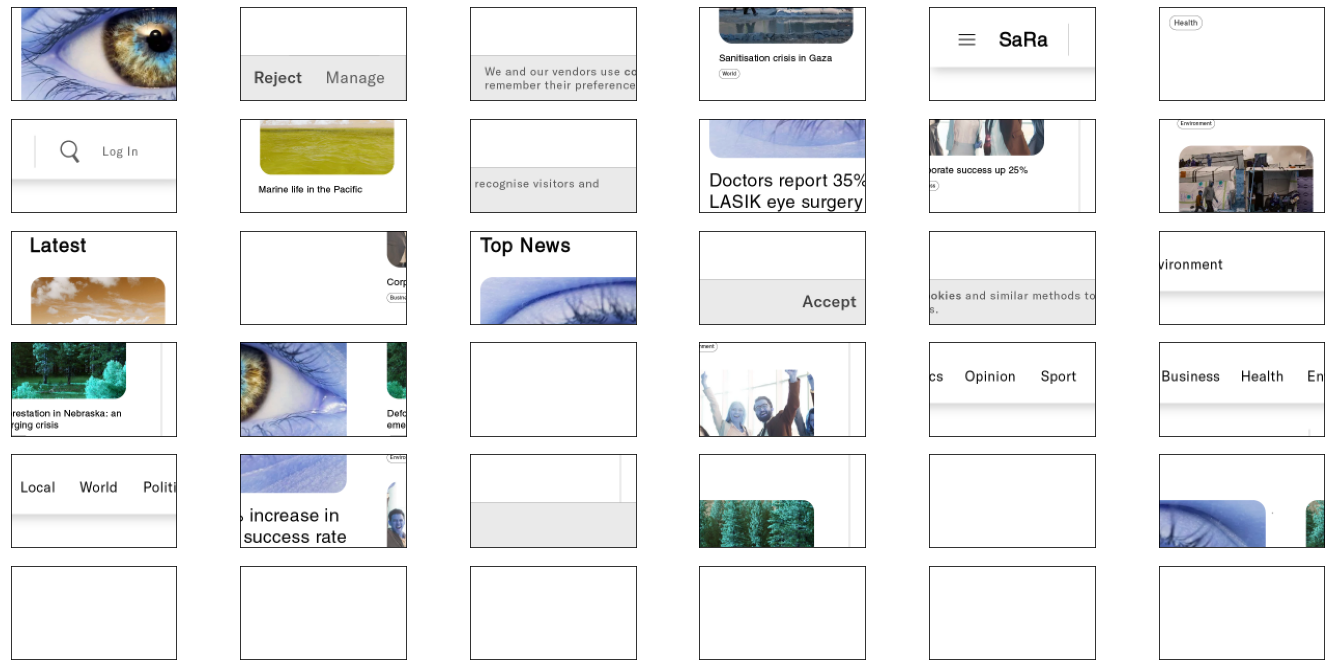

In [21]:
sara_list_sorted = sorted(sara_list_a, key=lambda x: x[1])

image_segments = []

for segment in sara_list_sorted:
    image_crop = img_a.copy()
    coordinates = index_to_coordinates(segment[0], GRID_SIZE, img_a.shape)
    image_crop = image_crop[coordinates[1]:coordinates[3], coordinates[0]:coordinates[2]]

    image_segments.append(image_crop)

plt.figure(figsize=(24, 12))
for i in range(GRID_SIZE * GRID_SIZE):
    plt.subplot(GRID_SIZE, GRID_SIZE, i + 1)
    plt.imshow(cv2.cvtColor(image_segments[i], cv2.COLOR_BGR2RGB))
    plt.xticks([]), plt.yticks([])

plt.show()


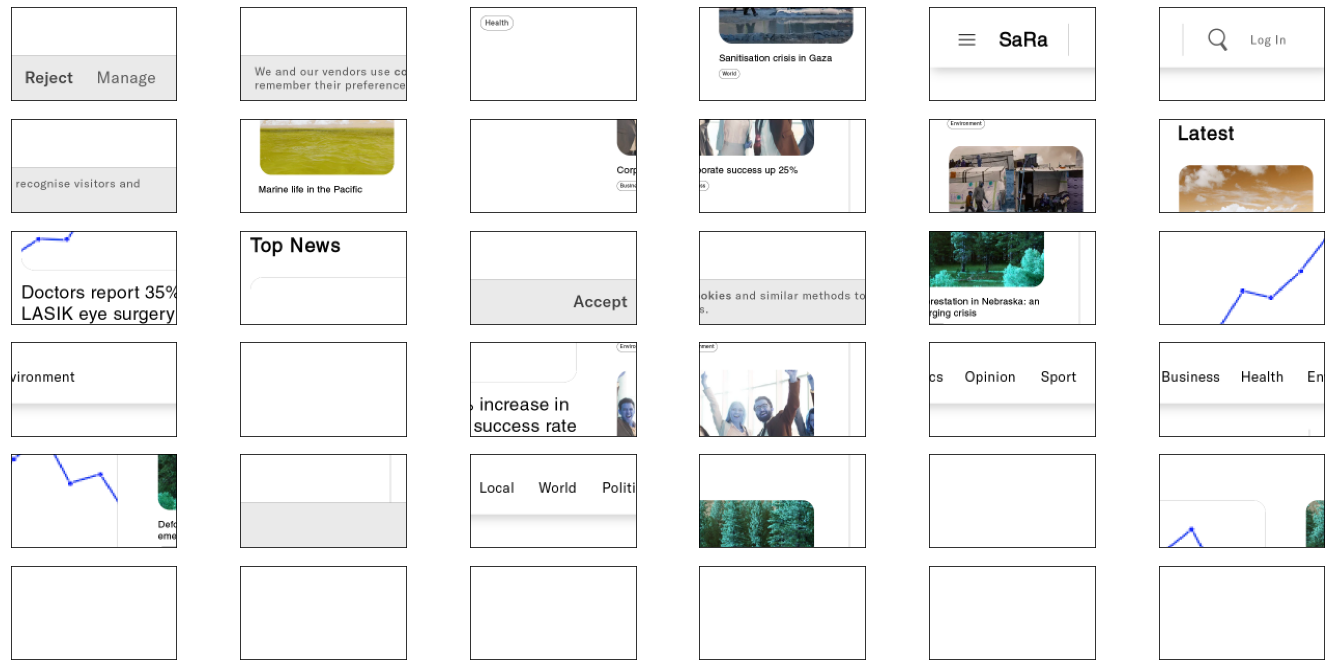

In [22]:
sara_list_sorted = sorted(sara_list_b, key=lambda x: x[1])

image_segments = []

for segment in sara_list_sorted:
    image_crop = img_b.copy()
    coordinates = index_to_coordinates(segment[0], GRID_SIZE, img_a.shape)
    image_crop = image_crop[coordinates[1]:coordinates[3], coordinates[0]:coordinates[2]]

    image_segments.append(image_crop)

plt.figure(figsize=(24, 12))
for i in range(GRID_SIZE * GRID_SIZE):
    plt.subplot(GRID_SIZE, GRID_SIZE, i + 1)
    plt.imshow(cv2.cvtColor(image_segments[i], cv2.COLOR_BGR2RGB))
    plt.xticks([]), plt.yticks([])

plt.show()


In [23]:
sara_list_sorted = sorted(sara_list, key=lambda x: x[1])

image_segments = []

for segment in sara_list_sorted:
    image_crop = img_b.copy()
    coordinates = index_to_coordinates(segment[0], GRID_SIZE, img_a.shape)
    image_crop = image_crop[coordinates[1]:coordinates[3], coordinates[0]:coordinates[2]]

    image_segments.append(image_crop)

plt.figure(figsize=(24, 12))
for i in range(GRID_SIZE * GRID_SIZE):
    plt.subplot(GRID_SIZE, GRID_SIZE, i + 1)
    plt.imshow(cv2.cvtColor(image_segments[i], cv2.COLOR_BGR2RGB))
    plt.xticks([]), plt.yticks([])

plt.show()


NameError: name 'sara_list' is not defined

/home/matthewkenely/anaconda3/envs/sara/lib/python3.6/site-packages/ipykernel_launcher.py:49: UserWarning: set_ticks() must have been called.


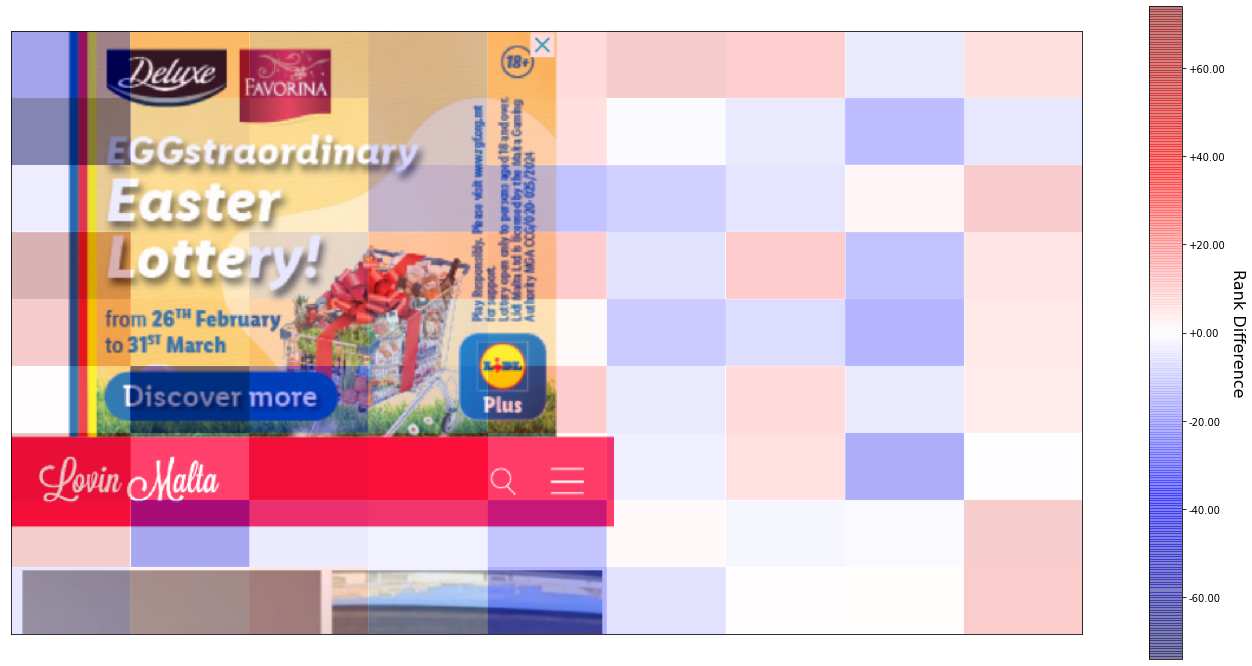

In [ ]:
from matplotlib.colors import LinearSegmentedColormap

# Calculate the difference in ranks between sara_list_a and sara_list_b, create a heatmap of the differences - each list is sorted by rank, index 0 = index in grid, index 1 = rank
diff = np.zeros((GRID_SIZE, GRID_SIZE))

sara_list_a_sorted = sorted(sara_list_a, key=lambda x: x[0])
sara_list_b_sorted = sorted(sara_list_b, key=lambda x: x[0])

for i in range(GRID_SIZE * GRID_SIZE):
    diff[i // GRID_SIZE][i % GRID_SIZE] = sara_list_a_sorted[i][1] - sara_list_b_sorted[i][1]

ncolors = 256
color_array = plt.get_cmap('seismic')(np.linspace(0, 1, 256))


# Make it so color_array is transparent in the middle and opaque at the extremes
color_array[:,-1] = np.abs(np.linspace(-1, 0.6,ncolors))

# Make minimum transparency 0.5 unless exactly 0 (which should be fully transparent)
color_array[:,-1] = np.maximum(color_array[:,-1], 0.4)


map_object = LinearSegmentedColormap.from_list(name='coolwarm_alpha',colors=color_array)
plt.register_cmap(cmap=map_object)



# Show image B
plt.figure(figsize=(24, 12))
# plt.imshow(cv2.cvtColor(img_b, cv2.COLOR_BGR2GRAY), cmap='gray')
# plt.imshow(cv2.cvtColor(img_a_original, cv2.COLOR_BGR2RGB), alpha=0.5)
plt.imshow(cv2.cvtColor(img_b_original, cv2.COLOR_BGR2RGB), alpha=1)
# Expand diff to twice its size
diff = cv2.resize(diff, (img_a_original.shape[1], img_a_original.shape[0]), interpolation=cv2.INTER_NEAREST)
# plt.imshow(img_b, alpha=1, cmap='gray')
plt.xticks([]), plt.yticks([])

# Show heatmap overlayed on top of image B
# Show heatmap overlayed on top of image B using the "coolwarm" colormap, adjust to the range such that a difference of 0 is white, more white = more transparent
heatmap = plt.imshow(diff, cmap='coolwarm_alpha', alpha=0.5, vmin=-np.max(np.abs(diff)), vmax=np.max(np.abs(diff)))
plt.xticks([]), plt.yticks([])

# Add a colorbar to the right of the image
cbar = plt.colorbar(heatmap, format='%+.2f')  # Use the format parameter to control decimal places

# Modify colorbar labels to include a plus sign for positive values
tick_labels = cbar.get_ticks()
tick_labels_str = [f'{label:+.2f}' if label >= 0 else f'{label:.2f}' for label in tick_labels]
cbar.set_ticklabels(tick_labels_str)

# Add cbar title "Rank Difference"
cbar.set_label('Rank Difference', labelpad=20, rotation=270, fontsize=16)

plt.show()

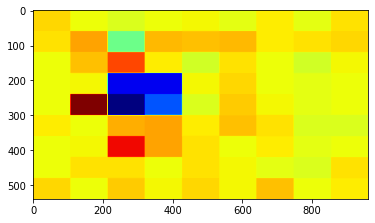

In [ ]:
plt.imshow(diff, cmap='jet')